# Computing Reduced Density Matrices from MPO

### Basics Imports

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s-%(levelname)s: %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.INFO
    #level=logging.DEBUG
)
logger = logging.getLogger('__name__')
import numpy as np
import pandas as pd
import sys

### TensorNetworks imports

In [ ]:
sys.path.append("../")
import tensornetworks as tn
import tn_quantum_circuits as tnqc
import gates as gt
from tensornetworks import contract_indices, contract_indices_one_tensor

### Imports QLM

In [ ]:
import qat.lang.AQASM as qlm
from qat.qpus import PyLinalg
qpu_p = PyLinalg()
from qlm_stuff import proccess_qresults

## 1. Functions for creating the MPS

In [ ]:
def apply_2qubit_gates(qubits, gates):
    """
    Executes product of tensor with a gate
    -o-o-o-o-o-..o-o-
     |   |   |     |
    """
    new_qubits = [0 for i in qubits]
    left = qubits[0]
    for i in range(1, len(qubits)):
        right = qubits[i]
        gate = gates[i-1]
        #new_qubits[i-1], left = phase_change(left, right, gate)
        new_qubits[i-1], left = tnqc.apply_2qubit_gate(left, right, gate)

    new_qubits[-1], new_qubits[0] = tnqc.apply_2qubit_gate(
        left, new_qubits[0], gates[-1])
     #new_qubits[-1], new_qubits[0] = phase_change(left, new_qubits[0], gates[-1])
    return new_qubits

In [ ]:
def get_angles(depth):
    theta = np.pi/4.0
    delta_theta = theta / (depth + 1)
    angles = []
    for i in range(depth):
        angles.append([(2 * i + 1) * delta_theta, (2 * i + 2) * delta_theta])
    return angles     

In [ ]:
def ansatz(nqubits, depth, angles):
    # Intitial State
    zeroket = np.zeros((1, 2, 1))
    zeroket[0][0][0] = 1
    zeroket = zeroket.astype(complex)
    #Initial State
    mps_ = [zeroket] * nqubits
    for depth_ in range(depth):
        # First Layer
        gates = [gt.x_rotation(angles[depth_][0]) for i in mps_]
        mps_ = tnqc.apply_local_gate(mps_, gates)
        ent_gates = [gt.controlz() for i in mps_]
        mps_ = apply_2qubit_gates(mps_, ent_gates)
        gates = [gt.z_rotation(angles[depth_][1]) for i in mps_]
        mps_ = tnqc.apply_local_gate(mps_, gates)
    return mps_

In [ ]:
def ansatz_qlm(nqubits, depth, angles):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for d_ in range(0, depth):
        for i in range(nqubits):
            qprog.apply(qlm.RX(angles[d_][0]), qbits[i])
        for i in range(nqubits-1):
            qprog.apply(qlm.Z.ctrl(), qbits[i], qbits[i+1])    
        qprog.apply(qlm.Z.ctrl(), qbits[nqubits-1], qbits[0])
        for i in range(nqubits):
            qprog.apply(qlm.RZ(angles[d_][1]), qbits[i])    
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ  

## 2. Creating MPS

In [ ]:
# MPS uisng My code
depth = 3
nqubits = 4 
mps = ansatz(nqubits, depth, get_angles(depth))

In [ ]:
# State of MPS
pdf_zalo = tnqc.get_state_from_mps(mps)

In [ ]:
#Stat of circuit for comparing with MPS computations
pdf, c= ansatz_qlm(nqubits, depth,  get_angles(depth))

In [ ]:
%qatdisplay c --svg

In [ ]:
# Testing if state from MPS is equat to state from QLM circuit
np.isclose(pdf["Amplitude"], pdf_zalo["Amplitude"]).all()

In [ ]:
[mps_.shape for mps_ in mps]

### Testing  Isometry

In [ ]:
# Identitidad: U.T @ U
tensor = mps[3]
iso = tn.contract_indices(tensor, tensor.conj(), [0, 1], [0, 1])
np.isclose(iso, np.eye(iso.shape[0])).all()

In [ ]:
#Proyector U @U.T
tensor = mps[3]
iso = tn.contract_indices(tensor, tensor.conj(), [2], [2])
projector = iso.reshape(np.product(iso.shape[:2]), np.product(iso.shape[:2]))
np.isclose(projector @ projector, projector).all()

In [ ]:
# Identitidad: U.T @ U
tensor = mps[0]
iso = tn.contract_indices(tensor, tensor.conj(), [1, 2], [1, 2])
np.isclose(iso, np.eye(iso.shape[0])).all()

## 2. Computing density matrix

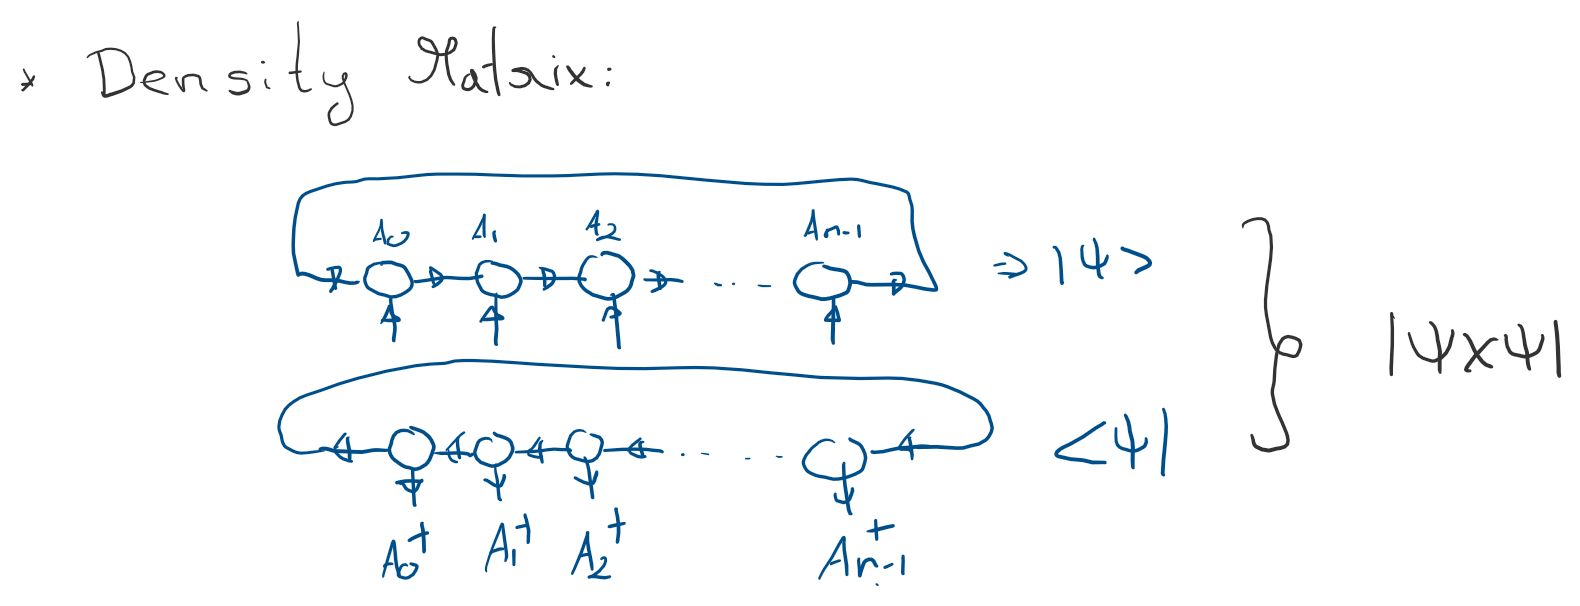

In [ ]:
[mps_.shape for mps_ in mps]

In [ ]:
# Naive Computation of density matrix: |Phi><Psi|
amp = np.array(pdf_zalo["Amplitude"])
amp = amp.reshape(amp.shape[0], 1)
rho0 = amp @ amp.conj().T

In [ ]:
# Computing Density Matrix using reduced_matrix for pure tensors
amp = np.array(pdf_zalo["Amplitude"])
amp = amp.reshape(tuple([2 for i in range(nqubits)]))
rho1 = tn.reduced_matrix(amp, [0, 1, 2, 3], [])

In [ ]:
#Testing both computations are equivalent
np.isclose(rho0, rho1).all()

## 3. Conputing Reduced Density Matrices from MPS

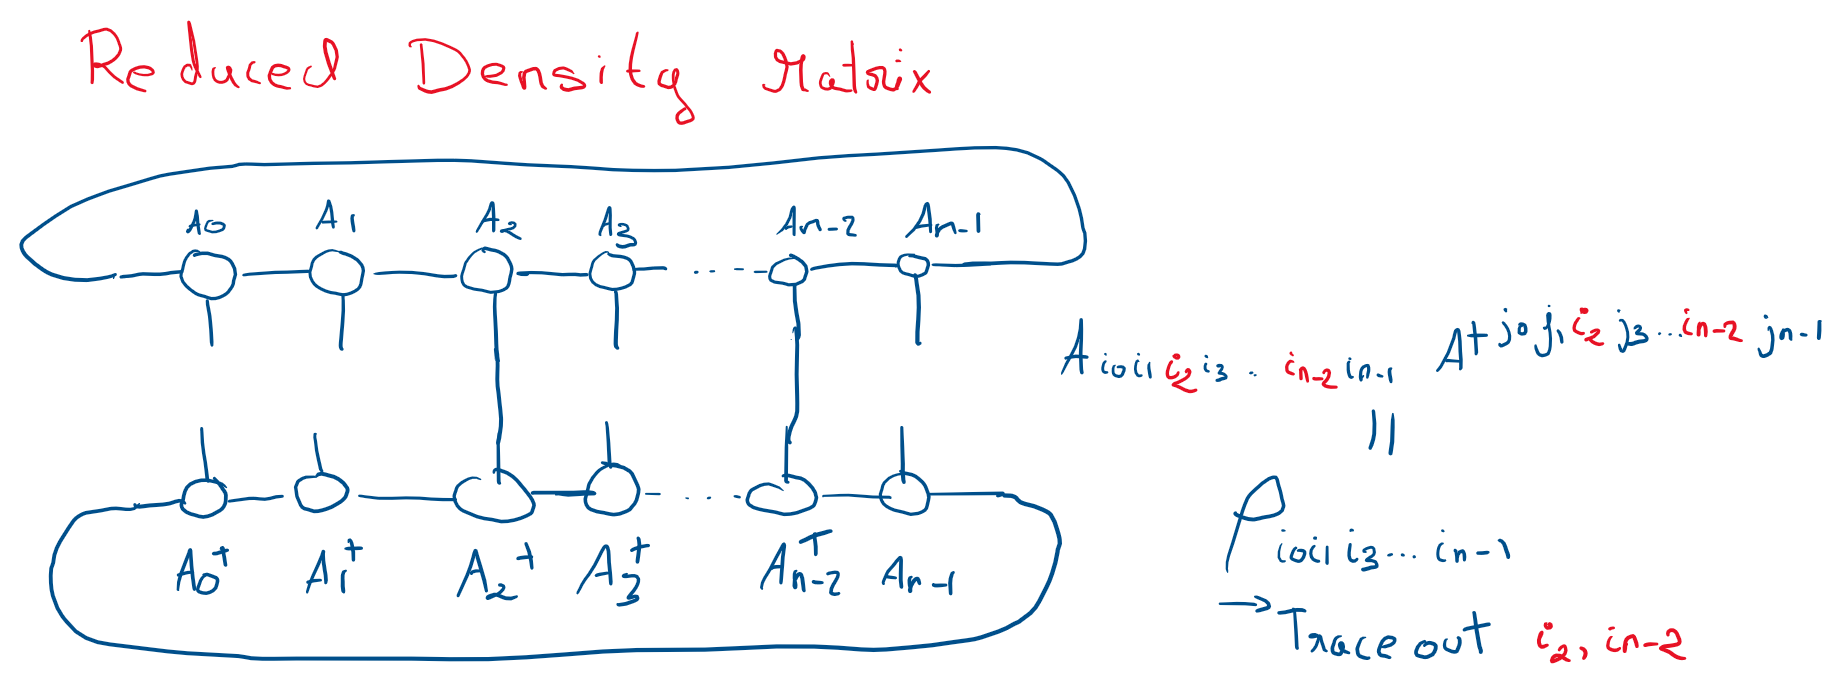


### 3.1 Site Operations

#### Step = 0
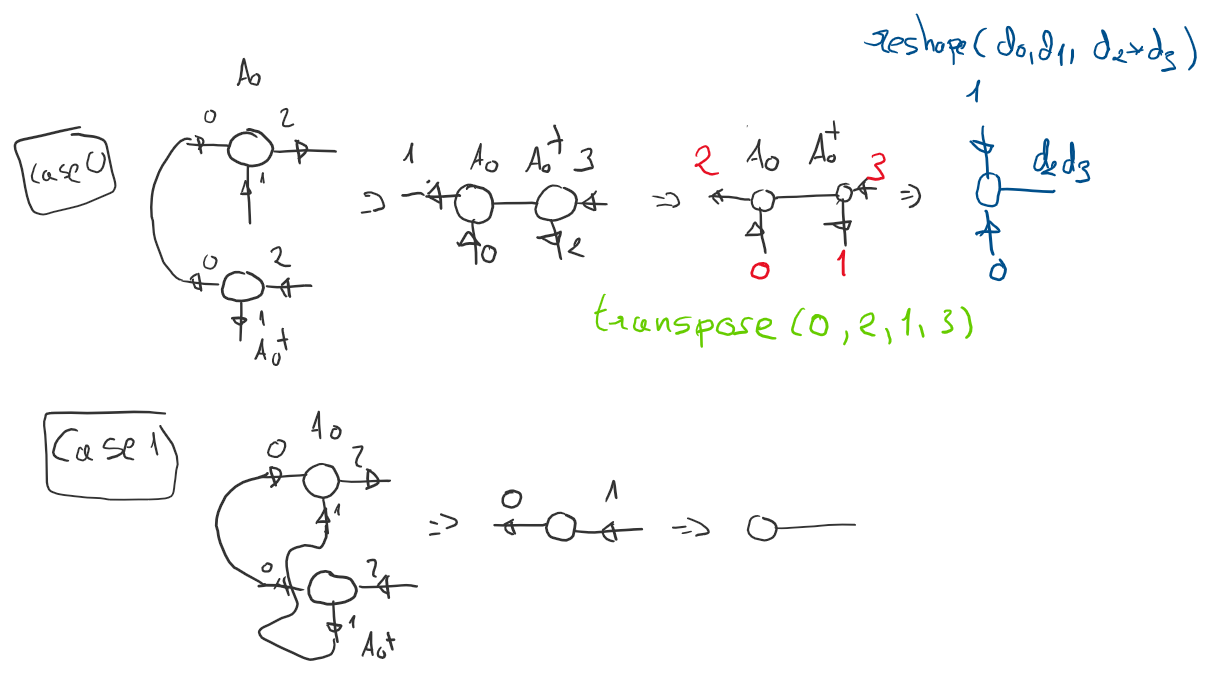


In [ ]:
tensor_0 = mps[0]
#Caso 0
tensor_0_0 = contract_indices(tensor_0, tensor_0.conj(), [0], [0])
tensor_0_0 = tensor_0_0.transpose(0, 2, 1, 3)
reshape = [
    tensor_0_0.shape[0],
    tensor_0_0.shape[1], 
    tensor_0_0.shape[2] * tensor_0_0.shape[3]
]
tensor_0_0 = tensor_0_0.reshape(reshape)
#Caso1
tensor_0_1 = contract_indices(tensor_0, tensor_0.conj(), [0, 1], [0, 1])
tensor_0_1 = tensor_0_1.reshape([tensor_0_1.shape[0] * tensor_0_1.shape[0]])

#### step i

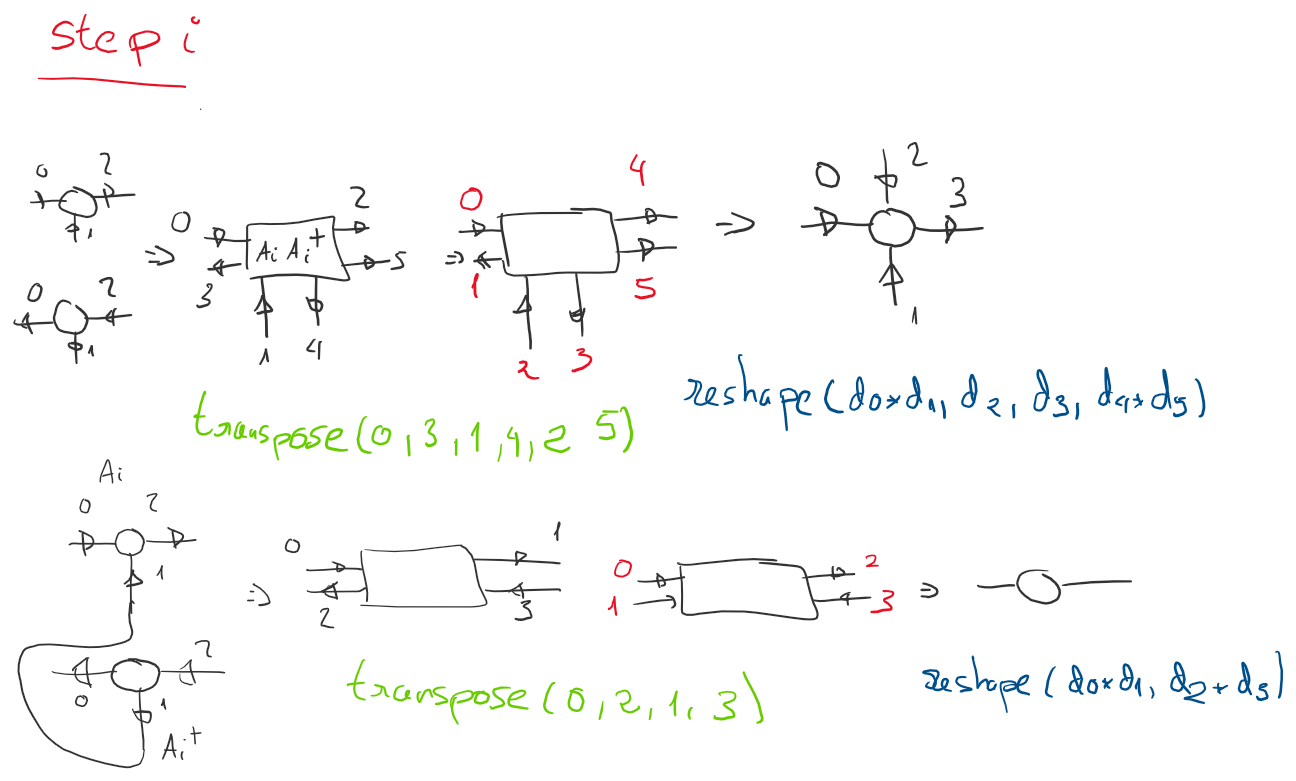

In [ ]:
tensor_1 = mps[1]

# Caso 0
tensor_1_0 = contract_indices(tensor_1, tensor_1.conj(), [], [])
tensor_1_0 = tensor_1_0.transpose(0, 3, 1, 4, 2, 5)
reshape = [
    tensor_1_0.shape[0] * tensor_1_0.shape[1],
    tensor_1_0.shape[2], tensor_1_0.shape[3],
    tensor_1_0.shape[4] * tensor_1_0.shape[5],
]
tensor_1_0 = tensor_1_0.reshape(reshape)

# Caso 1
tensor_1_1 = contract_indices(tensor_1, tensor_1.conj(), [1], [1])
tensor_1_1 = tensor_1_1.transpose(0, 2, 1, 3)

reshape = [
    tensor_1_1.shape[0] * tensor_1_1.shape[1], 
    tensor_1_1.shape[2] * tensor_1_1.shape[3]
]
tensor_1_1 = tensor_1_1.reshape(reshape)

In [ ]:
tensor_1_0.shape, tensor_1_1.shape

#### Last Site

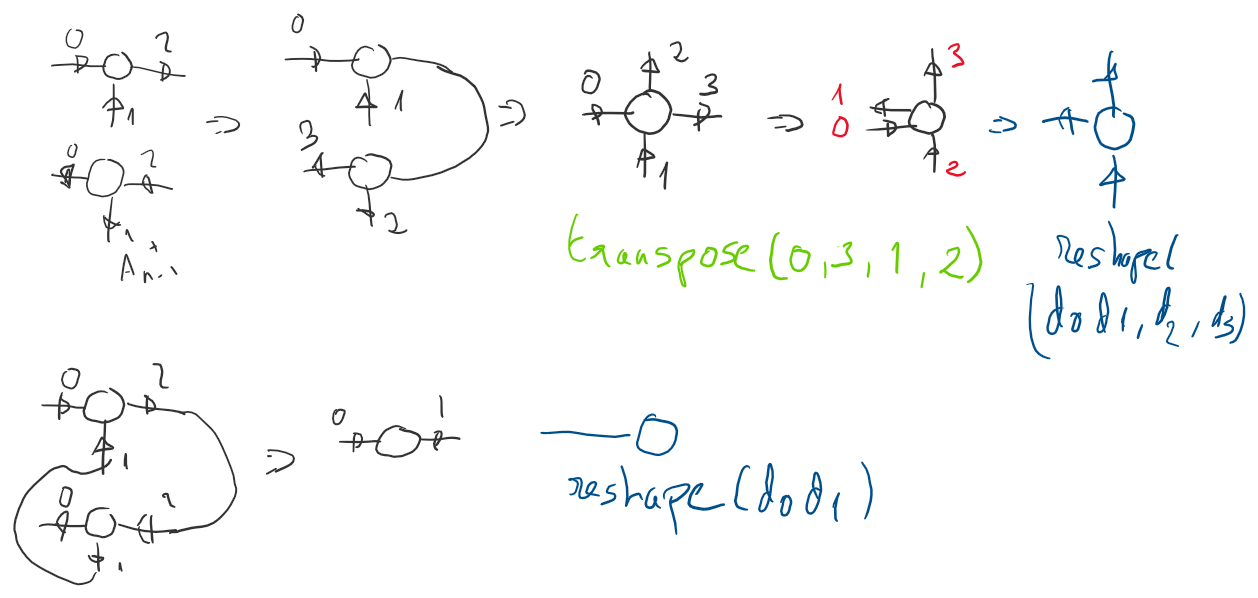

In [ ]:
tensor_f = mps[2]

# Caso 0
tensor_f_0 = contract_indices(tensor_f, tensor_f.conj(), [2], [2])
tensor_f_0 = tensor_f_0.transpose(0, 3, 1, 2)
reshape = [
    tensor_f_0.shape[0] * tensor_f_0.shape[1],
    tensor_f_0.shape[2], tensor_f_0.shape[3]
]
tensor_f_0 = tensor_f_0.reshape(reshape)

# Caso 1
tensor_f_1 = contract_indices(tensor_f, tensor_f.conj(), [1], [1])
tensor_f_1 = tensor_f_1.transpose(0, 2, 1, 3)

reshape = [
    tensor_f_1.shape[0] * tensor_f_1.shape[1], 
    tensor_f_1.shape[2] * tensor_f_1.shape[3]
]
tensor_f_1 = tensor_f_1.reshape(reshape)


In [ ]:
tensor_f_0.shape, tensor_f_1.shape

### 3.2 Operation on 2 consecutive sites

In [ ]:
from tensornetworks import mpo_contraction_0

#### Rank-3, Rank-4

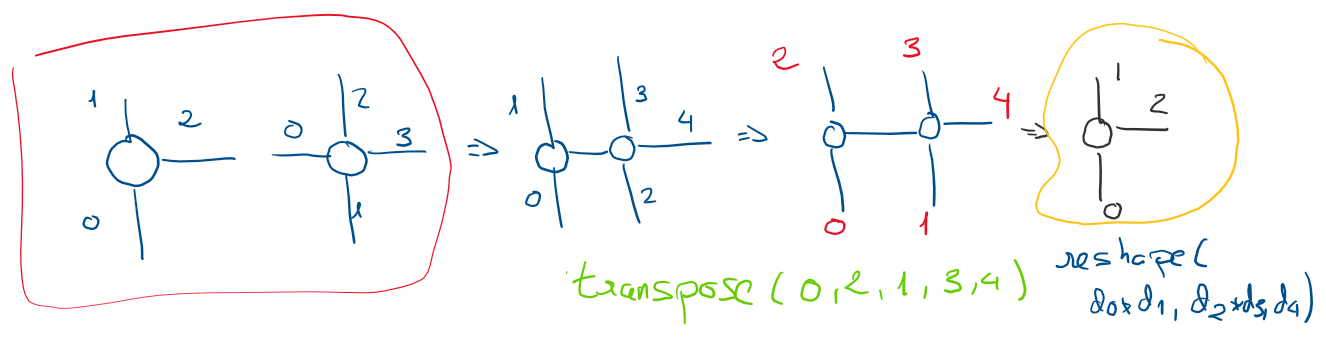


In [ ]:
tensor_out = mpo_contraction_0(tensor_0_0, tensor_1_0)

In [ ]:
tensor_out.shape

#### Rank 3 - Rank 2

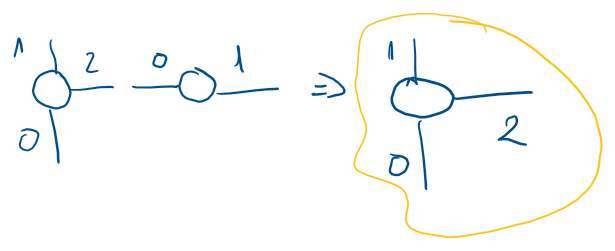

In [ ]:
tensor_out = mpo_contraction_0(tensor_0_0, tensor_1_1)

In [ ]:
tensor_out.shape

#### Rank 1- Rank 4

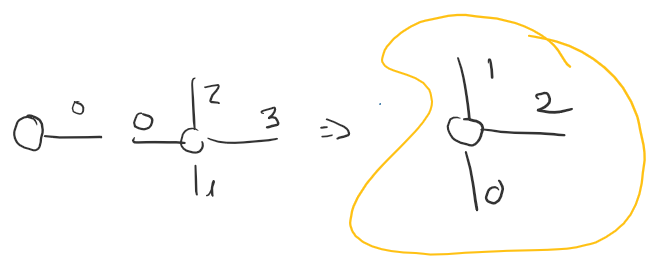

In [ ]:
tensor_out = mpo_contraction_0(tensor_0_1, tensor_1_0)

In [ ]:
tensor_out.shape

#### Rank 1 - Rank 2

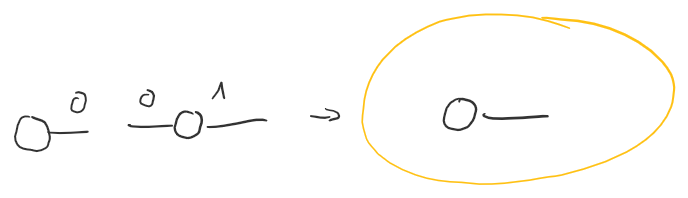

In [ ]:
tensor_out = mpo_contraction_0(tensor_0_1, tensor_1_1)

In [ ]:
tensor_out.shape

#### Rank 3 - Rank 3

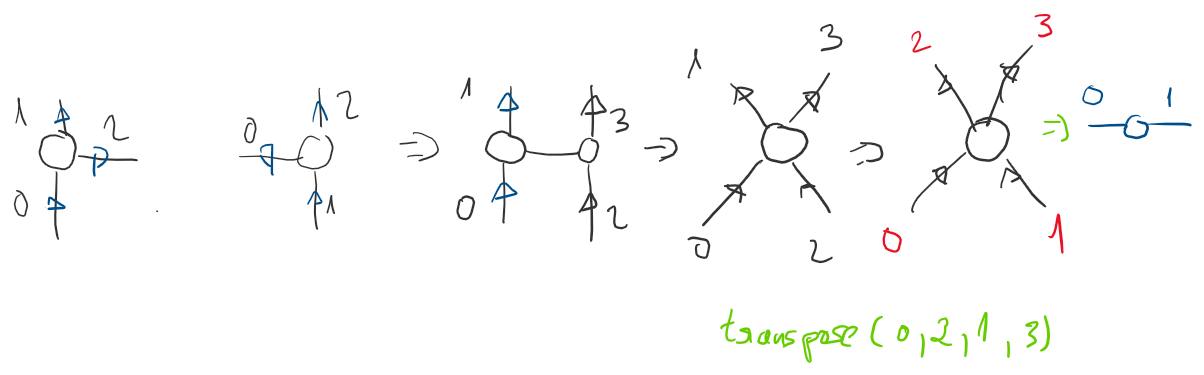

In [ ]:
tensor_out = mpo_contraction_0(tensor_0_0, tensor_1_0)
print(tensor_out.shape)
tensor_out = mpo_contraction_0(tensor_out, tensor_f_0)

In [ ]:
tensor_f_0.shape

### 3.2 Computing using Zipper strategy

Finally we use the zipper strategy indicating which are the sites with no contraction (free) and with contraction

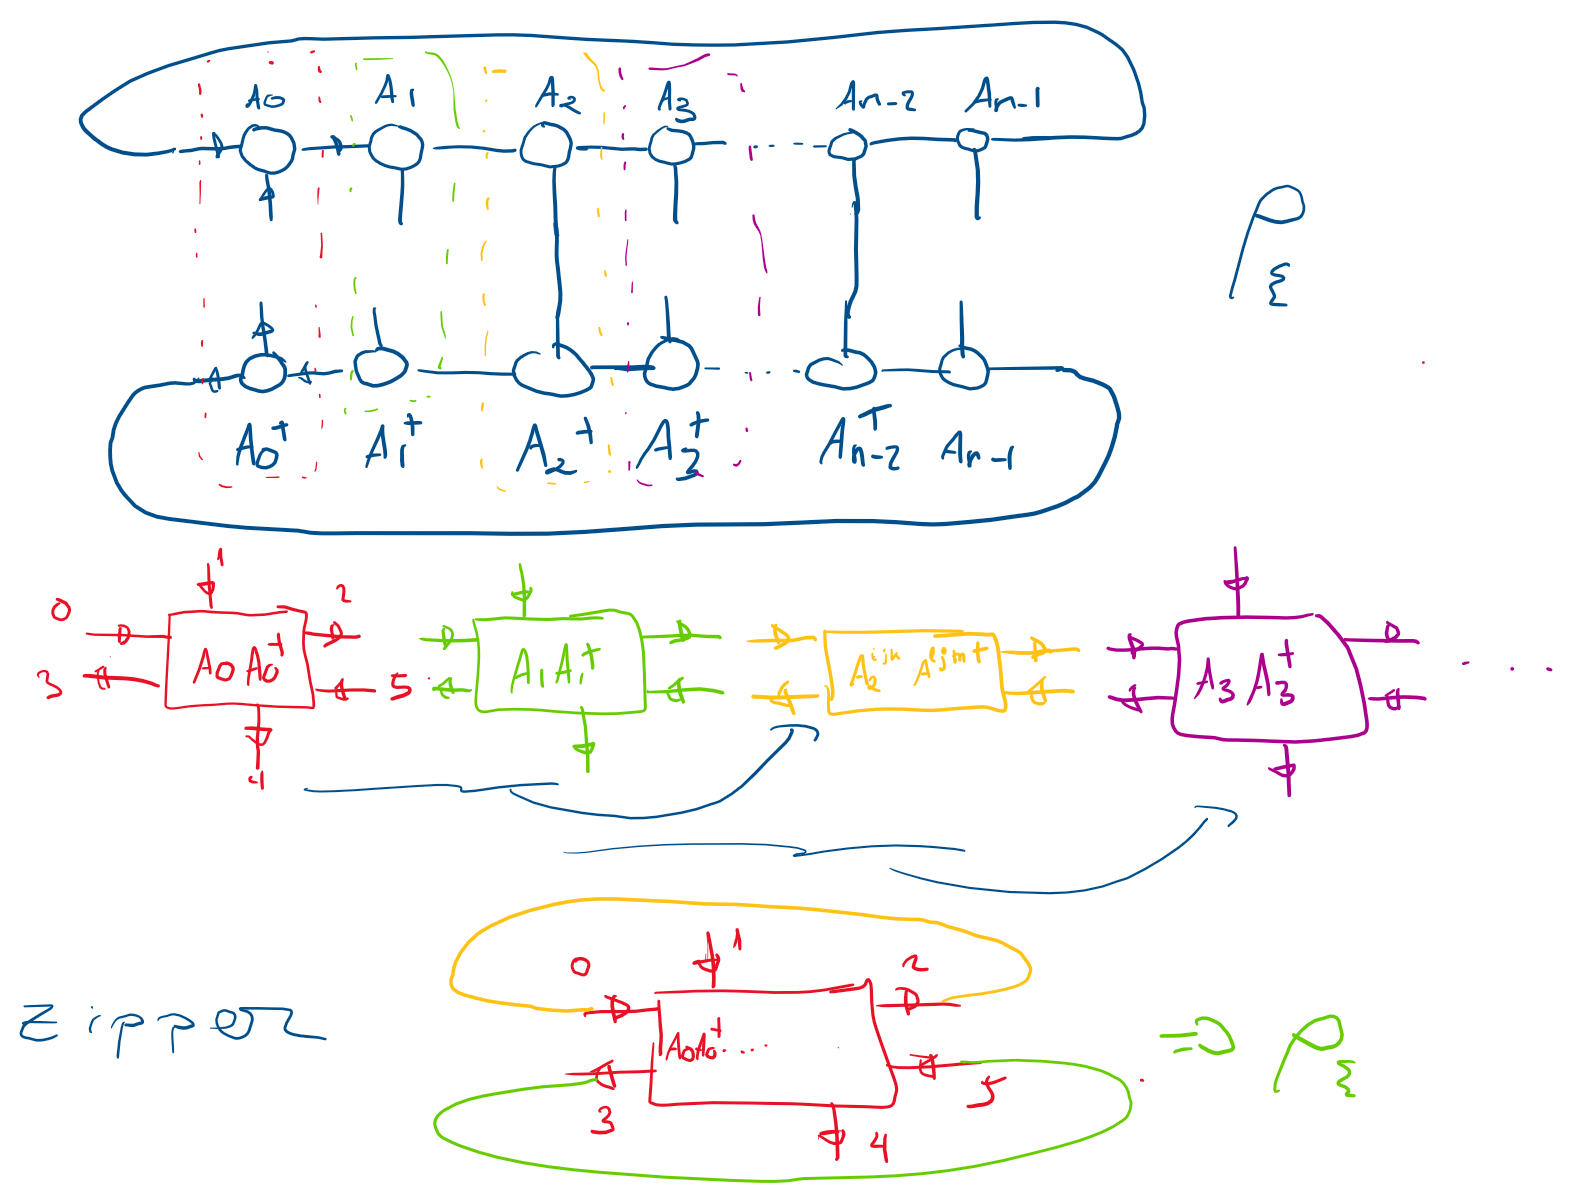

In [ ]:
def reduced_rho_mps(mps, free_indices, contraction_indices):
    # Starting Tensor for Denisty Matrix
    
    tensor = mps[0]
    
    if 0 in free_indices:
        #Caso 0
        tensor_out = contract_indices(tensor, tensor.conj(), [0], [0])
        tensor_out = tensor_out.transpose(0, 2, 1, 3)
        reshape = [
            tensor_out.shape[0],
            tensor_out.shape[1], 
            tensor_out.shape[2] * tensor_out.shape[3]
        ]
        tensor_out = tensor_out.reshape(reshape)
    elif i in contraction_indices:
        #Caso1
        tensor_out = contract_indices(tensor, tensor.conj(), [0, 1], [0, 1])
        tensor_out = tensor_out.reshape([tensor_out.shape[0] * tensor_out.shape[0]])      
    else:
        raise ValueError("Problem with site 0: {}".format(i))
    
    for i in range(1, len(mps)-1):
        tensor = mps[i]
        if i in free_indices:        
            # Caso 0
            tensor = contract_indices(tensor, tensor.conj(), [], [])
            tensor = tensor.transpose(0, 3, 1, 4, 2, 5)
            reshape = [
                tensor.shape[0] * tensor.shape[1],
                tensor.shape[2], tensor.shape[3],
                tensor.shape[4] * tensor.shape[5],
            ]
            tensor = tensor.reshape(reshape)
        elif i in contraction_indices:
            # Caso 1
            tensor = contract_indices(tensor, tensor.conj(), [1], [1])
            tensor = tensor.transpose(0, 2, 1, 3)

            reshape = [
                tensor.shape[0] * tensor.shape[1], 
                tensor.shape[2] * tensor.shape[3]
            ]
            tensor = tensor.reshape(reshape)
            
        else:
            raise ValueError("Problem with site i: {}".format(i))        
        
        tensor_out = mpo_contraction_0(tensor_out, tensor)
        
    final = len(mps) - 1
    tensor = mps[final]
    if final in free_indices:
        # Caso 0
        tensor = contract_indices(tensor, tensor.conj(), [2], [2])
        tensor = tensor.transpose(0, 3, 1, 2)
        reshape = [
            tensor.shape[0] * tensor.shape[1],
            tensor.shape[2], tensor.shape[3]
        ]
        tensor = tensor.reshape(reshape)
    elif final in contraction_indices:

        # Caso 1
        tensor = contract_indices(tensor, tensor.conj(), [0, 1], [0, 1])
        reshape = [
            tensor.shape[0] * tensor.shape[1]
        ]
        tensor = tensor.reshape(reshape)        
    else:
        raise ValueError("Problem with site i: {}".format(i)) 
    #tensor_out= contract_indices_one_tensor(tensor_out, [(0, 3)])
    print(tensor_out.shape, tensor.shape)
    tensor_out = mpo_contraction_0(tensor_out, tensor)
    
    return tensor_out   
    

In [ ]:
free = [0]
contraction = [1, 2, 3]

In [ ]:
a = reduced_rho_mps(mps, free, contraction)

In [ ]:
a.shape

In [ ]:
free = [0]
contraction = [1, 2, 3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

In [ ]:
 reduced_rho_mps(mps, free, contraction)

In [ ]:
tn.reduced_matrix(amp, free, contraction)

In [ ]:
free = [0, 1]
contraction = [2, 3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

In [ ]:
free = [0, 1, 2]
contraction = [3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

In [ ]:
free = [0, 2]
contraction = [1, 3]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

In [ ]:
free = [0, 3]
contraction = [1, 2]
np.isclose(
    tn.reduced_matrix(amp, free, contraction), 
    reduced_rho_mps(mps, free, contraction)
).all()

## Computing Norm of the MPS

In [ ]:
def compute_norm(mps):
    tensor_out = mps[0]
    tensor_out = contract_indices(tensor_out, tensor_out.conj(), [0, 1], [0, 1])
    for tensor in mps[1:-1]:
        tensor_out = contract_indices(tensor_out, tensor, [0], [0])
        tensor_out = contract_indices(tensor_out, tensor.conj(), [0, 1], [0, 1])
    tensor = mps[-1]
    tensor_out = contract_indices(tensor_out, tensor, [0], [0])
    tensor_out = contract_indices(tensor_out, tensor.conj(), [0, 1, 2], [0, 1, 2])  
    return tensor_out

In [ ]:
compute_norm(mps)

In [ ]:
pdf_zalo["Amplitude"] @ np.conj(pdf_zalo["Amplitude"])